## Import dependencies

In [1]:
import torch
from torch import nn

from torchvision.transforms import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from pathlib import Path
from time import time
from tqdm.auto import tqdm
import os

## Set up device-agnostic code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Load the data

In [3]:
# Set up the data directory path
data_dir = Path('data/')
data_dir

PosixPath('data')

In [4]:
# Get the training data
train_data = datasets.CIFAR10(root=data_dir,
                              train=True,
                              transform=transforms.ToTensor(),
                              target_transform=None,
                              download=True)

# Get the test data
test_data = datasets.CIFAR10(root=data_dir,
                             train=False,
                             transform=transforms.ToTensor(),
                             target_transform=None,
                             download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
len(train_data), len(test_data)

(50000, 10000)

In [6]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Visualize what we're working

In [7]:
image, label = train_data[0]

image, label

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

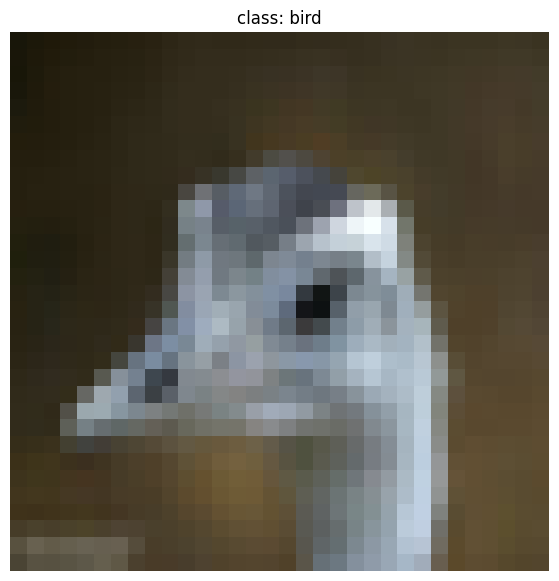

In [8]:
random_idx = torch.randint(0, len(train_data), size=(1,)).item()
image, label = train_data[random_idx]

plt.figure(figsize=(10, 7))
plt.imshow(image.permute(1, 2, 0))
plt.title(f'class: {class_names[label]}')
plt.axis(False)
plt.show()

## Prepare DataLoaders

In [9]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

In [10]:
image_batch, label_batch = next(iter(train_dataloader))

## Build a baseline model

In [11]:
class CIFAR10ModelV0(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=16),
        nn.Linear(in_features=16, out_features=output_shape)
    )

  def forward(self, X: torch.Tensor):
    return self.layer_stack(X)

In [12]:
model_0 = CIFAR10ModelV0(input_shape=3*32*32,
                         output_shape=len(class_names)).to(device)
model_0

CIFAR10ModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=1e-3)

In [14]:
def accuracy_fn(y_true, y_pred):
  correct = torch.sum(torch.eq(y_true, y_pred))
  total = len(y_true)

  return correct / total

In [15]:
epochs = 3
train_loss, train_acc = 0, 0
test_loss, test_acc = 0, 0

for epoch in range(epochs):
  # Training
  model_0.train()
  for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)

    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    acc = accuracy_fn(y_true=y,
                      y_pred=y_pred.argmax(axis=1))
    train_acc += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  # Testing
  model_0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model_0(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss

      acc = accuracy_fn(y_true=y,
                        y_pred=y_pred.argmax(axis=1))
      test_acc += acc

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f'Training loss: {train_loss} | Training accuracy: {train_acc} | Test loss: {test_loss} | Test accuracy: {test_acc}')

Training loss: 1.905249834060669 | Training accuracy: 0.32027751207351685 | Test loss: 1.8346904516220093 | Test accuracy: 0.3580271601676941
Training loss: 1.8101038932800293 | Training accuracy: 0.3668875992298126 | Test loss: 1.8404544591903687 | Test accuracy: 0.3450935482978821
Training loss: 1.7870526313781738 | Training accuracy: 0.3763943612575531 | Test loss: 1.7986479997634888 | Test accuracy: 0.3755034804344177


In [16]:
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          accuracy_fn=accuracy_fn):
  train_loss, train_acc = 0, 0

  model.to(device)
  model.train()
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    acc = accuracy_fn(y_true=y,
                      y_pred=y_pred.argmax(axis=1))
    train_acc += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         accuracy_fn=accuracy_fn):
  test_loss, test_acc = 0, 0

  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss

      acc = accuracy_fn(y_true=y,
                        y_pred=y_pred.argmax(axis=1))
      test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

In [17]:
epochs = 3


for epoch in range(epochs):
  # Training
  train_loss, train_acc = train(model=model_0,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device,
                                accuracy_fn=accuracy_fn)

  # Testing
  test_loss, test_acc = test(model=model_0,
                             dataloader=test_dataloader,
                             loss_fn=loss_fn,
                             device=device,
                             accuracy_fn=accuracy_fn)

  print(f'Training loss: {train_loss} | Training accuracy: {train_acc} | Test loss: {test_loss} | Test accuracy: {test_acc}')

Training loss: 1.7736821174621582 | Training accuracy: 0.38197776675224304 | Test loss: 1.7703299522399902 | Test accuracy: 0.3777955174446106
Training loss: 1.7589466571807861 | Training accuracy: 0.38761594891548157 | Test loss: 1.8084628582000732 | Test accuracy: 0.36731231212615967
Training loss: 1.7528585195541382 | Training accuracy: 0.3924744129180908 | Test loss: 1.7791290283203125 | Test accuracy: 0.36731231212615967


In [18]:
def fit(model: torch.nn.Module,
        epochs: int,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device=device,
        accuracy_fn=accuracy_fn):
  history = {
      'train_losses': [],
      'train_accuracies': [],
      'test_losses': [],
      'test_accuracies': [],
  }

  start_time = time()

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train(model=model,
                                  dataloader=train_dataloader,
                                  loss_fn=loss_fn,
                                  optimizer=optimizer,
                                  device=device,
                                  accuracy_fn=accuracy_fn)
    history['train_losses'].append(train_loss.item())
    history['train_accuracies'].append(train_acc.item())

    test_loss, test_acc = test(model=model,
                               dataloader=test_dataloader,
                               loss_fn=loss_fn,
                               device=device,
                               accuracy_fn=accuracy_fn)
    history['test_losses'].append(test_loss.item())
    history['test_accuracies'].append(test_acc.item())

    print(f'Training loss:  {train_loss} | Training accuracy: {train_acc} | Test loss: {test_loss} | Test accuracy: {test_acc}')

  end_time = time()
  history['training_time'] = end_time - start_time

  history['device'] = device

  return history

In [19]:
history_0 = fit(model=model_0,
              epochs=50,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              device=device,
              accuracy_fn=accuracy_fn)

  0%|          | 0/50 [00:00<?, ?it/s]

Training loss:  1.74417245388031 | Training accuracy: 0.39373400807380676 | Test loss: 1.7836542129516602 | Test accuracy: 0.3818889856338501
Training loss:  1.738136887550354 | Training accuracy: 0.3979126811027527 | Test loss: 1.7458082437515259 | Test accuracy: 0.38857826590538025
Training loss:  1.7346242666244507 | Training accuracy: 0.3992922306060791 | Test loss: 1.7568798065185547 | Test accuracy: 0.38937699794769287
Training loss:  1.7258012294769287 | Training accuracy: 0.40229126811027527 | Test loss: 1.7330021858215332 | Test accuracy: 0.3987619876861572
Training loss:  1.7234108448028564 | Training accuracy: 0.4040307104587555 | Test loss: 1.7374181747436523 | Test accuracy: 0.39996007084846497
Training loss:  1.7232755422592163 | Training accuracy: 0.4030910134315491 | Test loss: 1.7349779605865479 | Test accuracy: 0.39277157187461853
Training loss:  1.7166692018508911 | Training accuracy: 0.40826934576034546 | Test loss: 1.7346891164779663 | Test accuracy: 0.395067900419

In [20]:
history_0['training_time']

898.5743792057037

In [21]:
history_0['train_accuracies']

[0.39373400807380676,
 0.3979126811027527,
 0.3992922306060791,
 0.40229126811027527,
 0.4040307104587555,
 0.4030910134315491,
 0.40826934576034546,
 0.40862923860549927,
 0.40914908051490784,
 0.4114883244037628,
 0.4135076701641083,
 0.41194817423820496,
 0.4137875735759735,
 0.41796624660491943,
 0.4159069061279297,
 0.4171465039253235,
 0.41726648807525635,
 0.41726648807525635,
 0.41650670766830444,
 0.41912588477134705,
 0.41978567838668823,
 0.41898593306541443,
 0.42112523317337036,
 0.42298465967178345,
 0.42192497849464417,
 0.4224248230457306,
 0.4232845604419708,
 0.4218650162220001,
 0.42360445857048035,
 0.4240643084049225,
 0.4246841073036194,
 0.42280471324920654,
 0.42386436462402344,
 0.4263235628604889,
 0.42528390884399414,
 0.4268234074115753,
 0.427743136882782,
 0.4269033968448639,
 0.42572376132011414,
 0.4268234074115753,
 0.4276231527328491,
 0.4271233081817627,
 0.42848289012908936,
 0.4300623834133148,
 0.428822785615921,
 0.4289027452468872,
 0.42836293578

In [22]:
def plot_loss_curves(train_losses, test_losses):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

  axs[0].plot(range(len(train_losses)), train_losses, color='blue')
  axs[0].set_title('Training Loss Curve')
  axs[0].set_xlabel('Number of Epochs')
  axs[0].set_ylabel('Loss')

  axs[1].plot(range(len(test_losses)), test_losses, color='orange')
  axs[1].set_title('Test Loss Curve')
  axs[1].set_xlabel('Number of Epochs')
  axs[1].set_ylabel('Loss')

  plt.show()

def plot_accuracy_curves(train_accuracies, test_accuracies):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

  axs[0].plot(range(len(train_accuracies)), train_accuracies)
  axs[0].set_title('Training Accuracy Curve')
  axs[0].set_xlabel('Number of Epochs')
  axs[0].set_ylabel('Accuracy')

  axs[1].plot(range(len(test_accuracies)), test_accuracies)
  axs[1].set_title('Test Accuracy Curve')
  axs[1].set_xlabel('Number of Epochs')
  axs[1].set_ylabel('Accuracy')

  plt.show()

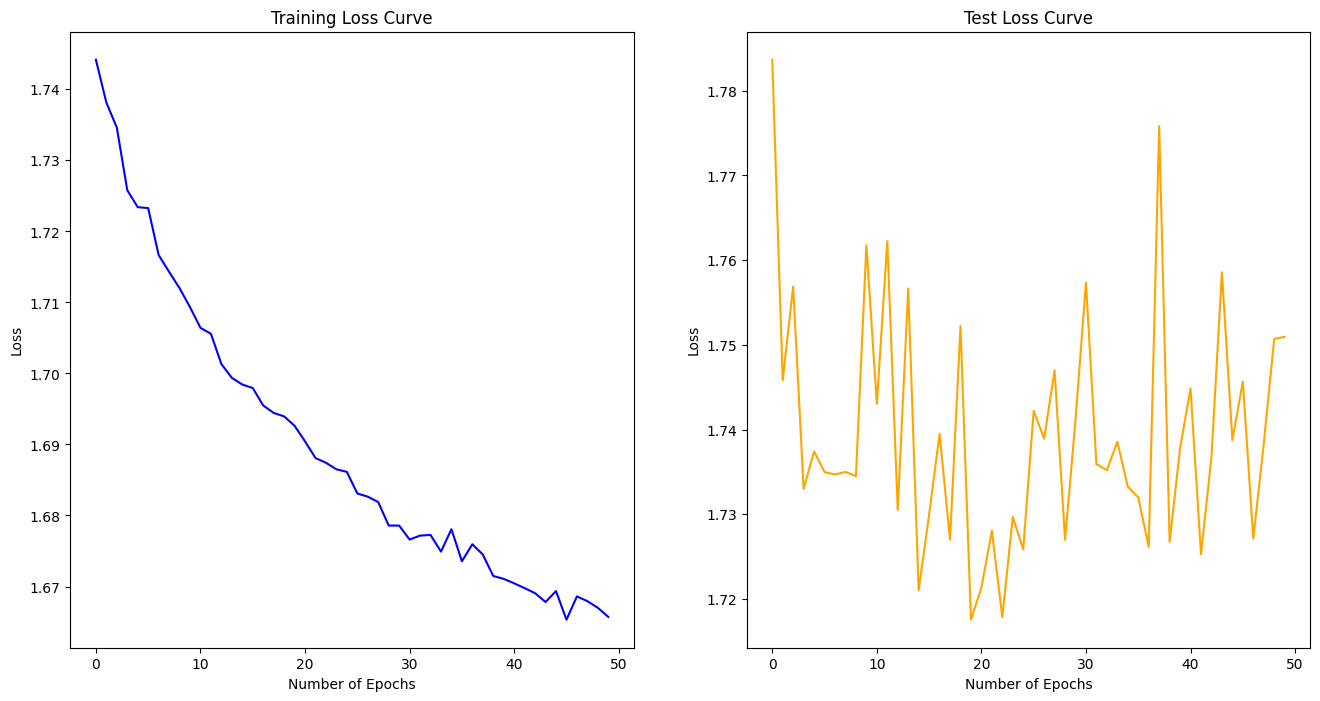

In [23]:
plot_loss_curves(train_losses=history_0['train_losses'],
                 test_losses=history_0['test_losses'])

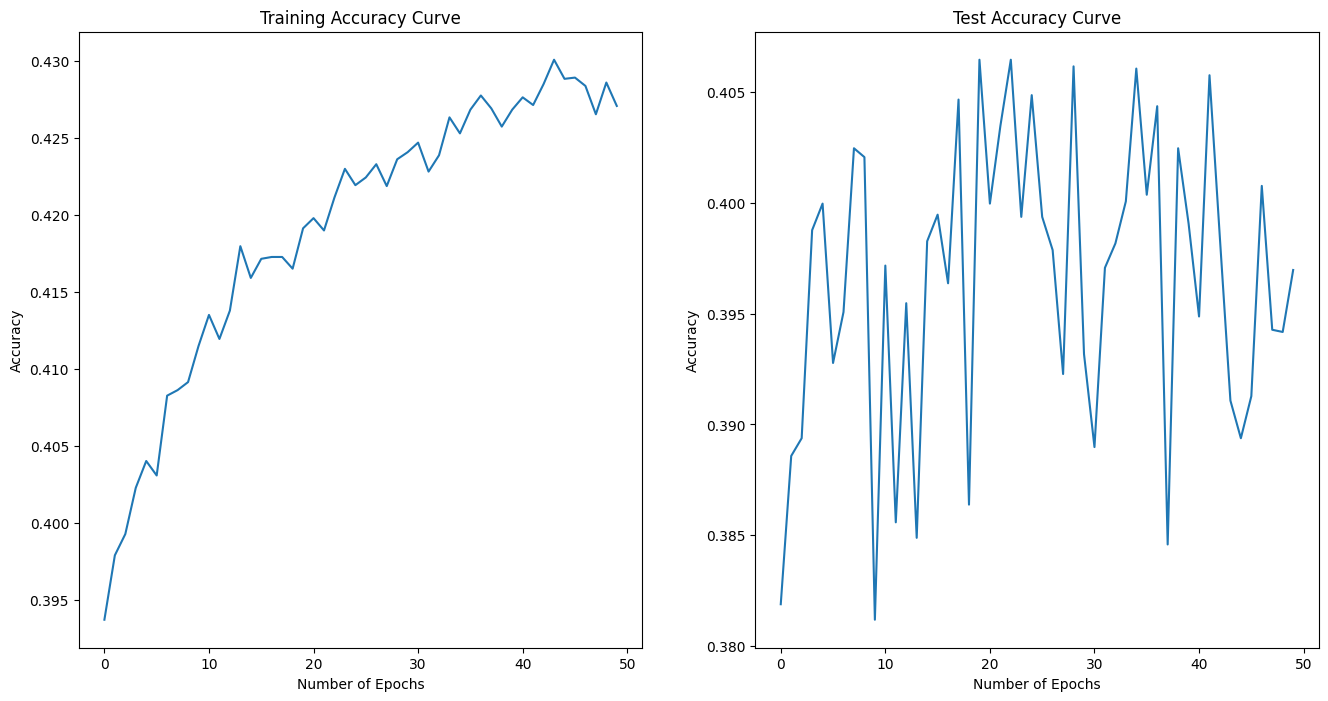

In [24]:
plot_accuracy_curves(train_accuracies=history_0['train_accuracies'],
                     test_accuracies=history_0['test_accuracies'])

## Create a model with ReLU layers for learning non-linear patterns

In [25]:
class CIFAR10ModelV1(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=16),
        nn.ReLU()
    )

  def forward(self, X: torch.Tensor):
    return self.layer_stack(X)

In [26]:
model_1 = CIFAR10ModelV1(input_shape=3*32*32,
                         output_shape=len(class_names)).to(device)

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=1e-3)

In [29]:
history_1 = fit(model=model_1,
                epochs=50,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                accuracy_fn=accuracy_fn)

  0%|          | 0/50 [00:00<?, ?it/s]

Training loss:  2.264253616333008 | Training accuracy: 0.24474167823791504 | Test loss: 2.1042604446411133 | Test accuracy: 0.28614217042922974
Training loss:  2.0954878330230713 | Training accuracy: 0.29456573724746704 | Test loss: 2.1132113933563232 | Test accuracy: 0.28564298152923584
Training loss:  2.0760338306427 | Training accuracy: 0.30542227625846863 | Test loss: 2.0853147506713867 | Test accuracy: 0.29622602462768555
Training loss:  2.0644760131835938 | Training accuracy: 0.3091810643672943 | Test loss: 2.0995991230010986 | Test accuracy: 0.3015175759792328
Training loss:  2.054384231567383 | Training accuracy: 0.3149791955947876 | Test loss: 2.060253620147705 | Test accuracy: 0.3110024034976959
Training loss:  2.0472569465637207 | Training accuracy: 0.3175183832645416 | Test loss: 2.0689260959625244 | Test accuracy: 0.30301517248153687
Training loss:  2.0396344661712646 | Training accuracy: 0.32257676124572754 | Test loss: 2.034463405609131 | Test accuracy: 0.318091064691543

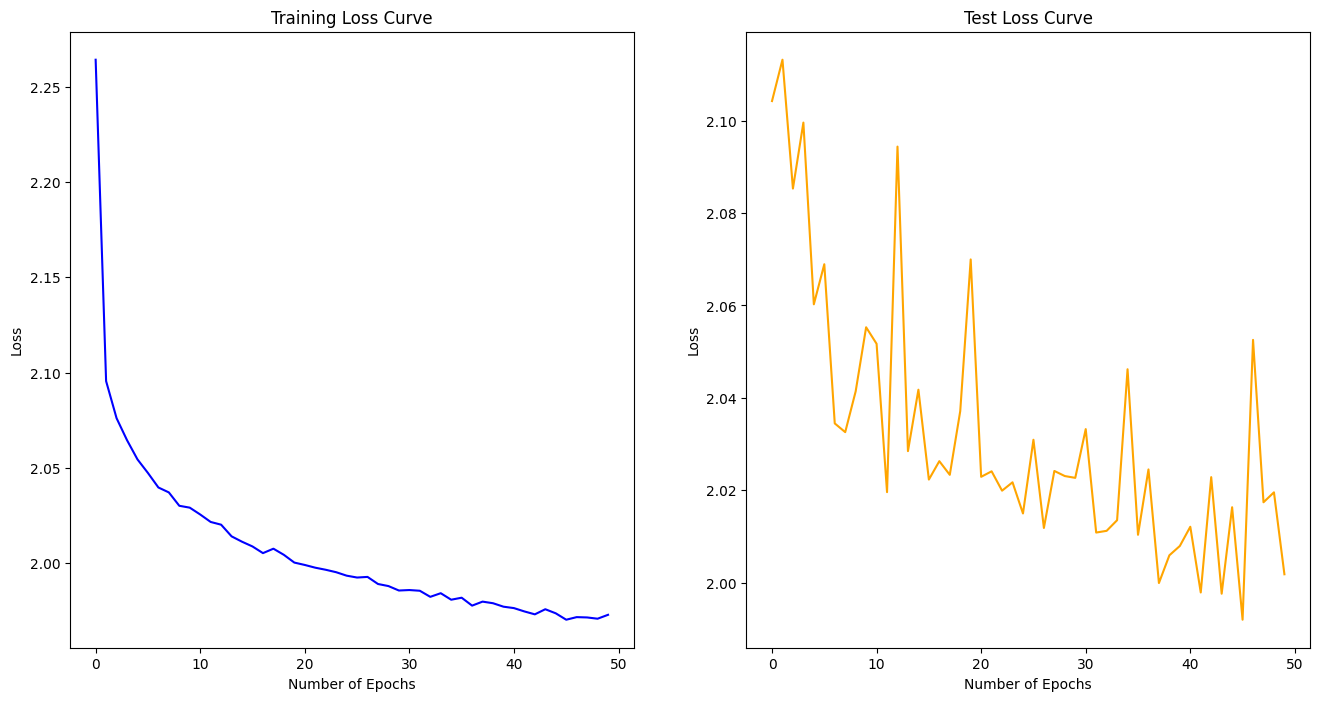

In [30]:
plot_loss_curves(train_losses=history_1['train_losses'],
                 test_losses=history_1['test_losses'])

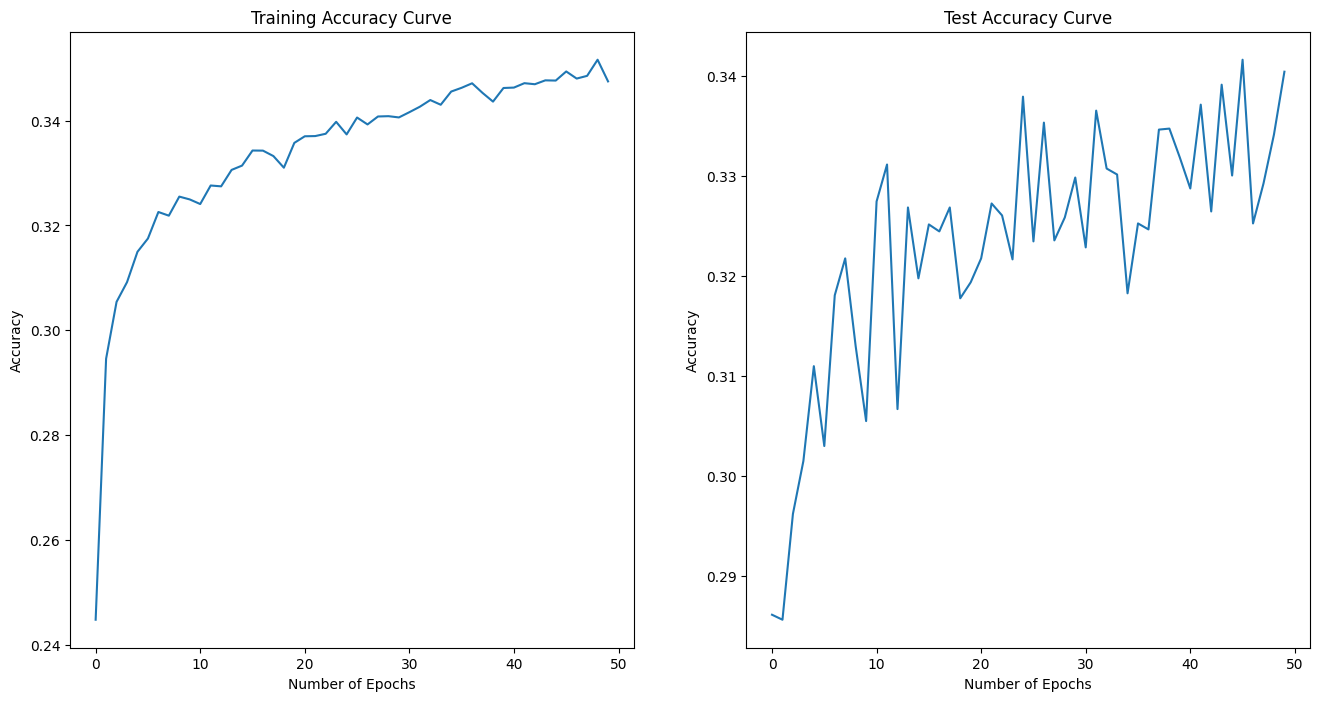

In [31]:
plot_accuracy_curves(train_accuracies=history_1['train_accuracies'],
                     test_accuracies=history_1['test_accuracies'])

## Create a convolutional neural network

In [74]:
class CIFAR10ModelV2(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=16,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=16,
                  out_channels=32,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=1)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=32,
                  out_channels=32,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,
                  out_channels=32,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=1)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=32*34*34,
                  out_features=output_shape)
    )

  def forward(self, X: torch.Tensor):
    return self.classifier(self.block_2(self.block_1(X)))

In [75]:
model_2 = CIFAR10ModelV2(input_shape=3,
                         output_shape=10)

In [76]:
image_tensor = torch.randn(1, 3, 32, 32)
model_2(image_tensor)

torch.Size([1, 32, 33, 33])
torch.Size([1, 32, 34, 34])
torch.Size([1, 10])


tensor([[-0.0153, -0.0439, -0.0169, -0.0024, -0.0202, -0.0476, -0.0204,  0.0225,
          0.0456, -0.0486]], grad_fn=<AddmmBackward0>)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=1e-3)

history_2 = fit(model=model_2,
                epochs=50,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                accuracy_fn=accuracy_fn)

  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34, 34])
torch.Size([32, 10])
torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34, 34])
torch.Size([32, 10])
torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34, 34])
torch.Size([32, 10])
torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34, 34])
torch.Size([32, 10])
torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34, 34])
torch.Size([32, 10])
torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34, 34])
torch.Size([32, 10])
torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34, 34])
torch.Size([32, 10])
torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34, 34])
torch.Size([32, 10])
torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34, 34])
torch.Size([32, 10])
torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34, 34])
torch.Size([32, 10])
torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34, 34])
torch.Size([32, 10])
torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34, 34])
torch.Size([32, 10])
torch.Size([32, 32, 33, 33])
torch.Size([32, 32, 34,

In [38]:
for X, y in train_dataloader:
  print(X.shape)
  break

torch.Size([32, 3, 32, 32])


In [ ]:
plot_loss_curves(train_losses=history_2['train_losses'],
                 test_losses=history_2['test_losses'])

In [ ]:
plot_accuracy_curves(train_accuracies=history_2['train_accuracies'],
                     test_accuracies=history_2['test_accuracies'])